# IMPORTS

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection as skms
import matplotlib.pyplot as plt

# DATA IMPORTS

In [4]:
# Read the data
df = pd.read_csv('finaldf.csv')


df_test = pd.read_csv('finaltest.csv')
df_test['weight'] = df_test['weight'].fillna(df_test['weight'].mean())
df_test['late_order'] = True
print(df_test.head())
m = len(df_test)
df_def = pd.concat([df, df_test])
df_def.tail()
k = len(df_def)
print(n, m, k)

       order_id origin_port    3pl customs_procedures logistic_hub  \
0  0e364fa5c795   Rotterdam  v_002                CRF       Warsaw   
1  3ef49bd5a55b   Barcelona  v_002                CRF        Venlo   
2  9ab5b9685bd5   Rotterdam  v_004                DTD   Bratislava   
3  bfce5b4fc4fa   Rotterdam  v_002                DTD         Rome   
4  d94453ec8ec5   Barcelona  v_001                CRF   Bratislava   

     customer  product_id  units  weight  material_handling  dist_origin_hub  \
0      Munich     1687644    477  1974.0                5.0        1135.6449   
1      Berlin     1699689    240  2369.0                0.0        1153.4178   
2       Paris     1652615    506   850.0                5.0         995.7185   
3     Hanover     1669740    553  2072.0                2.0        1269.2365   
4  Copenhagen     1695138    482   357.0                2.0        1397.4140   

   dist_hub_customer  dist_origin_customer        origin_port_coord  \
0           816.0497       

NameError: name 'n' is not defined

In [14]:
df.head()
avg = df["customer"].groupby(df['3pl']).value_counts()
print(avg)


3pl    customer
v_001  Berlin      703
       Milan       692
       Madrid      648
       Vienna      469
       Paris       452
                  ... 
v_004  Prague      629
       Bordeaux    628
       Bremen      623
       Helsinki    615
       Porto       433
Name: customer, Length: 112, dtype: int64


In [133]:
df_true = df[df['late_order'] == 1]
z = len(df_true)
df_false = df[df['late_order'] == 0].head(z)

df = pd.concat([df_true, df_false, df_test])
print(len(df),2*z + m)

82875 82875


# ANALISIS

In [135]:


def get_X_y(df, target):

    X = df.drop(['order_id', "logistic_hub", 'dist_origin_hub',
                "origin_port_coord", "logistic_hub_coord", "customer_coord", "dist_hub_customer", 
                'material_handling'], axis=1).dropna()
    if target:
        y = X['late_order']
        X = X.drop(['late_order'], axis=1)
    X['total_weight'] = X['weight']*X['units']
    X = X.drop(["units", "weight"], axis=1)

    return X if not target else (X, y)

X, y = get_X_y(df, True)
y = y.head(2*z)

X_enc = pd.get_dummies(X, columns= ["3pl", "origin_port", "customs_procedures", "customer"])
X_ori_enc = X_enc.head(2*z) 
X_test_enc = X_enc.tail(m)

X_train_enc, X_val_enc, y_train, y_val = skms.train_test_split(X_ori_enc, y, test_size=0.2)

print(len(X_train_enc), len(y_train))


43449 43449


In [136]:
from sklearn.tree import DecisionTreeClassifier
xval = [i for i in range(2, 30)]
rc = np.array([None for _ in range(2, 30)])

for i in range(2, 30):
    modelt = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    modelt.fit(X_train_enc, y_train)
    y_pred = np.array(modelt.predict_proba(X_val_enc)) 
    rc[i-2] = sk.metrics.roc_auc_score(y_val, y_pred.T[1])

defmodel = DecisionTreeClassifier(criterion="entropy", max_depth=3)
defmodel.fit(X_train_enc, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

[0.6821371025916527 0.7036450827589985 0.7213135913017491
 0.7345186034863079 0.7452306015207241 0.7546062439016189
 0.7618000624550164 0.7681039885514503 0.7650834932449326
 0.7618201813500589 0.7551622338882058 0.7498620999746709
 0.7434015109069836 0.7332987238620469 0.7258657836816405
 0.7132952200895252 0.7054452408084277 0.6991731795162732
 0.6879871925181982 0.6791095394003559 0.6767513913393902
 0.6717092775937001 0.6619557830416325 0.660600647492823 0.65619316878258
 0.6525430215536248 0.650493385815796 0.6474370595538277]


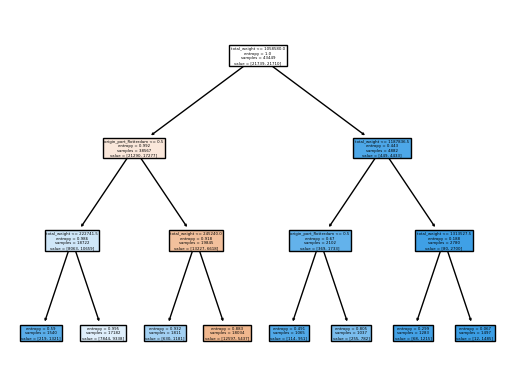

In [137]:
from sklearn.tree import plot_tree
defmodel = DecisionTreeClassifier(criterion="entropy", max_depth=3)
defmodel.fit(X_train_enc, y_train)
plot_tree(defmodel, filled=True, feature_names=X_train_enc.columns)
print(rc)

In [72]:
y_pred = defmodel.predict_proba(X_val_enc)

scr = sk.metrics.roc_auc_score(y_val, y_pred.T[1])
print(scr)

0.767196467570528


In [73]:
y_def = defmodel.predict_proba(X_test_enc)

print(y_def.T[1])


[0.31600832 0.32112117 0.30752014 ... 0.33948864 0.67851852 0.44174757]


In [59]:
submission = pd.DataFrame({"order_id": df_test.order_id, "late_order": y_def.T[1]})
submission.to_csv("submission_kaggle_def2.csv", index=False)